<a href="https://colab.research.google.com/github/comparativechrono/PedNet/blob/main/pedigree_pipeline_enriched.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedigree Network Analysis Pipeline

This notebook provides an end‑to‑end workflow:
1. **Load or simulate pedigrees** in PED format
2. **Convert to directed graphs** and visualise neatly with Graphviz
3. **Simulate or read multi‑sample VCFs**
4. **Run network‑aware segregation scoring** to prioritise causal variants
5. Summarise results

Run each section top‑to‑bottom, or use *Runtime ▶ Run all*.

## 0. Set‑up & imports

In [16]:
%%bash
apt install graphviz libgraphviz-dev

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [17]:
%%bash
pip -q install networkx pygraphviz powerlaw pandas > /dev/null 2>&1 || true

In [18]:
import networkx as nx, matplotlib.pyplot as plt, pandas as pd, random, powerlaw
from collections import defaultdict
%matplotlib inline

## 1. Pedigree helpers

In [19]:
import networkx as nx, pandas as pd

def ped_to_graph(ped_path):
    cols = ['fam','id','dad','mom','sex','phen']
    # read everything as string to avoid implicit ints
    df = pd.read_csv(ped_path, sep=r'\s+', header=None, names=cols, dtype=str)

    G = nx.DiGraph()
    for _, r in df.iterrows():
        G.add_node(
            r['id'],
            family=r['fam'],
            sex=int(r['sex']),
            phenotype=int(r['phen'])
        )
    for _, r in df.iterrows():
        if r['dad'] != '0':
            G.add_edge(r['dad'], r['id'])
        if r['mom'] != '0':
            G.add_edge(r['mom'], r['id'])
    return G


def graphviz_pos(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog='dot')
    except Exception:
        return nx.spring_layout(G, seed=42)

def plot_pedigree(G, title="Pedigree"):
    pos = graphviz_pos(G)
    colors = ['red' if G.nodes[n].get('phenotype',0)==2 else 'lightblue' for n in G]
    nx.draw(G, pos, node_color=colors, with_labels=True, arrows=True)
    plt.title(title)
    plt.show()

# ---------------- pedigree helper utilities -----------------
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share ≥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs
# ------------------------------------------------------------


## 2. Example pedigrees (simulated)

In [20]:
ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''
open('ad_complete.ped','w').write(ped_AD)

ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

156

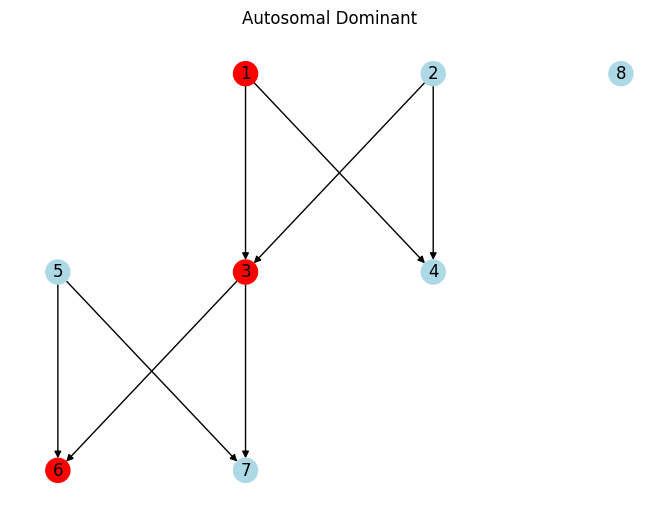

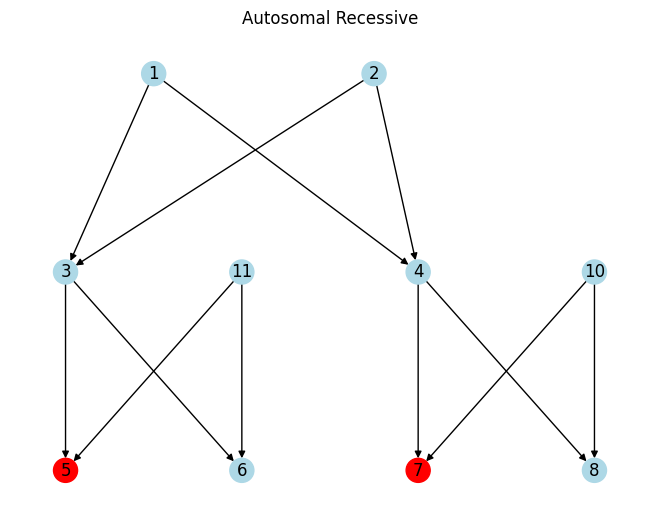

In [21]:
G_ad = ped_to_graph('ad_complete.ped')
G_ar = ped_to_graph('ar_complete.ped')
plot_pedigree(G_ad, 'Autosomal Dominant')
plot_pedigree(G_ar, 'Autosomal Recessive')

## 3. Variant simulation

In [22]:
def simulate_variant_table(G, mode='AD', n_bg=5, seed=1):
    random.seed(seed)
    samples = list(G.nodes)
    phen = nx.get_node_attributes(G,'phenotype')
    vars = {}
    # causal
    causal = 'chr1:100000_A>T'
    gt = {s:0 for s in samples}
    if mode=='AD':
        for s in samples:
            if phen[s]==2:
                gt[s]=1
        any_aff = [n for n in samples if phen[n]==2][0]
        for p in G.predecessors(any_aff):
            gt[p]=1
    else:
        for s in samples:
            if phen[s]==2:
                gt[s]=2
                for p in G.predecessors(s):
                    gt[p]=1
    vars[causal]=gt
    # background
    for i in range(n_bg):
        vid=f'chr1:{100200+i}_G>C'
        vars[vid]={s:random.choices([0,1,2],[0.8,0.18,0.02])[0] for s in samples}
    return vars

vars_AD = simulate_variant_table(G_ad, 'AD')
vars_AR = simulate_variant_table(G_ar, 'AR')

## 4. Network‑aware segregation scoring

In [23]:
from collections import defaultdict

def parents(G,n): return list(G.predecessors(n))
def aff(G): return [n for n,d in G.nodes(data='phenotype') if d==2]
def unaff(G): return [n for n,d in G.nodes(data='phenotype') if d!=2]

_ALLOWED = {
 'AD': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,'_'):{1,2}},
 'AR': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,'_'):{1,2}},
}

def allowed_child_set(mode,gp,gm):
    k=(gp,gm) if (gp,gm) in _ALLOWED[mode] else (gm,gp)
    if k not in _ALLOWED[mode]:
        k=(2,'_') if 2 in (gp,gm) else (1,'_')
    return _ALLOWED[mode].get(k,{0,1,2})

def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl

def segregation_network_score(G, gt, mode='AD', w_edge=.6,w_gen=.2,w_bet=.2):
    phen = nx.get_node_attributes(G,'phenotype')
    # edge penalty
    bad=0; total=0
    for child in G:
        prnts=parents(G,child)
        gp,gm=[gt.get(p,0) for p in prnts+[0,0]][:2]
        if gt[child] not in allowed_child_set(mode,gp,gm):
            bad+=1
        total+=1
    edge_score=1-bad/total
    # generation continuity
    gen=generations(G)
    gens_total=max(gen.values())+1
    alt_gens={gen[n] for n in G if gt[n]>0}
    if mode=='AD': gen_score=len(alt_gens)/gens_total
    else: gen_score=1-len(alt_gens)/gens_total
    gen_score=max(0,min(1,gen_score))
    # carrier betweenness
    het_car=[n for n in G if gt[n]==1 and phen[n]!=2]
    if het_car:
        bet=nx.betweenness_centrality(G)
        cb=sum(bet[n] for n in het_car)/len(het_car)
        cb/=max(bet.values()) if bet else 1
        bet_score=cb if mode=='AR' else 1-cb
    else:
        bet_score=0 if mode=='AR' else 1
    return round(w_edge*edge_score+w_gen*gen_score+w_bet*bet_score,3)

def scan_variants(G, vars_dict, mode='AD'):
    scores={vid:segregation_network_score(G,gt,mode) for vid,gt in vars_dict.items()}
    best=max(scores,key=scores.get)
    return best, scores

best_AD, scores_AD = scan_variants(G_ad, vars_AD, 'AD')
best_AR, scores_AR = scan_variants(G_ar, vars_AR, 'AR')
print('Best variant in AD:', best_AD, scores_AD[best_AD])
print('Best variant in AR:', best_AR, scores_AR[best_AR])

Best variant in AD: chr1:100000_A>T 0.925
Best variant in AR: chr1:100202_G>C 0.84


## 4b. Graph‑level Network Analysis
This section computes conventional graph‑theoretic statistics for each pedigree and assesses whether they show small‑world or power‑law behaviour.
Results are stored in a DataFrame for convenient inspection or export.

In [24]:

import numpy as np
import powerlaw
import itertools as it
from math import log10
from collections import OrderedDict

from collections import OrderedDict
import networkx as nx, numpy as np, powerlaw
import statistics as st

def graph_metrics(G):
    """Return an OrderedDict of network statistics; robust to disconnected graphs."""
    G_u = G.to_undirected()
    metrics = OrderedDict()

    # ---------- basic sizes ----------
    metrics['n_nodes']   = G.number_of_nodes()
    metrics['n_edges']   = G.number_of_edges()
    metrics['n_components'] = nx.number_connected_components(G_u)

    # ---------- centralities (averaged over ALL nodes) ----------
    deg_cent  = list(nx.degree_centrality(G_u).values())
    bet_cent  = list(nx.betweenness_centrality(G_u).values())
    clos_cent = list(nx.closeness_centrality(G_u).values())
    metrics['avg_degree_centrality'] = float(np.mean(deg_cent))
    metrics['avg_betweenness']       = float(np.mean(bet_cent))
    metrics['avg_closeness']         = float(np.mean(clos_cent))

    # ---------- clustering ----------
    metrics['avg_clustering'] = nx.average_clustering(G_u)

    # ---------- choose a CORE (largest connected component) for path-metrics ----------
    if metrics['n_components'] == 1:
        core = G_u
    else:
        core_nodes = max(nx.connected_components(G_u), key=len)
        core = G_u.subgraph(core_nodes)

    # ---------- diameter & average path on CORE ----------
    try:
        metrics['diameter'] = nx.diameter(core)
        metrics['avg_path_len'] = nx.average_shortest_path_length(core)
    except nx.NetworkXError:
        metrics['diameter']      = None
        metrics['avg_path_len']  = None

    # ---------- small-world sigma (CORE vs random ER) ----------
    n_core = core.number_of_nodes()
    m_core = core.number_of_edges()
    if n_core > 1 and m_core > 0:
        C_core = nx.average_clustering(core)
        p_er   = (2*m_core) / (n_core*(n_core-1))
        C_rand = p_er                                    # expected clustering in ER
        try:
            L_rand = nx.average_shortest_path_length(nx.gnm_random_graph(n_core, m_core))
            L_core = metrics['avg_path_len']
            metrics['sigma_small_world'] = (C_core/C_rand) / (L_core/L_rand) if L_core else None
        except Exception:
            metrics['sigma_small_world'] = None
    else:
        metrics['sigma_small_world'] = None

    # ---------- power-law exponent on full graph ----------
    degs = [d for _, d in G_u.degree()]
    if len(set(degs)) > 1:
        fit = powerlaw.Fit(degs, discrete=True, verbose=False)
        metrics['pl_alpha'] = round(fit.power_law.alpha, 3)
        metrics['pl_xmin']  = fit.power_law.xmin
    else:
        metrics['pl_alpha'] = None
        metrics['pl_xmin']  = None

    return metrics

# Compute for both example pedigrees
metrics_ad = graph_metrics(G_ad)
metrics_ar = graph_metrics(G_ar)
print('Graph metrics (AD):', metrics_ad)
print('Graph metrics (AR):', metrics_ar)

metrics_df = pd.DataFrame([metrics_ad, metrics_ar], index=['AD','AR'])
metrics_df


Graph metrics (AD): OrderedDict([('n_nodes', 8), ('n_edges', 8), ('n_components', 2), ('avg_degree_centrality', 0.2857142857142857), ('avg_betweenness', 0.1130952380952381), ('avg_closeness', 0.4059601113172541), ('avg_clustering', 0.0), ('diameter', 4), ('avg_path_len', 1.9047619047619047), ('sigma_small_world', 0.0), ('pl_alpha', np.float64(3.586)), ('pl_xmin', np.float64(2.0))])
Graph metrics (AR): OrderedDict([('n_nodes', 10), ('n_edges', 12), ('n_components', 1), ('avg_degree_centrality', 0.2666666666666667), ('avg_betweenness', 0.1916666666666667), ('avg_closeness', 0.41), ('avg_clustering', 0.0), ('diameter', 6), ('avg_path_len', 2.533333333333333), ('sigma_small_world', None), ('pl_alpha', np.float64(3.346)), ('pl_xmin', np.float64(2.0))])


,n_nodes,n_edges,n_components,avg_degree_centrality,avg_betweenness,avg_closeness,avg_clustering,diameter,avg_path_len,sigma_small_world,pl_alpha,pl_xmin
AD,8,8,2,0.285714,0.113095,0.40596,0.0,4,1.904762,0.0,3.586,2.0
AR,10,12,1,0.266667,0.191667,0.41000,0.0,6,2.533333,NaN,3.346,2.0


## 4c. Pedigree‑specific Feature Extraction & Inheritance Classification

In [25]:

def pedigree_features(G):
    phen = nx.get_node_attributes(G,'phenotype')
    aff_nodes = [n for n,p in phen.items() if p==2]
    unaff_nodes = [n for n,p in phen.items() if p!=2]
    # ratio affected with affected parent
    aff_aff_parent = 0
    for n in aff_nodes:
        if any(phen.get(p,0)==2 for p in parents(G,n)):
            aff_aff_parent +=1
    ratio_aff_parent = aff_aff_parent/len(aff_nodes) if aff_nodes else 0
    # generation coverage
    gen = generations(G)
    gens_aff = {gen[n] for n in aff_nodes}
    gen_cov = len(gens_aff)/(max(gen.values())+1) if gen else 0
    # sibling clustering
    sib_pairs=0; aa_pairs=0
    for n in aff_nodes:
        for sib in siblings(G,n):
            if sib in aff_nodes:
                aa_pairs+=1
            sib_pairs+=1
    sibling_aff_ratio = aa_pairs/sib_pairs if sib_pairs else 0
    # betweenness carriers
    bet = nx.betweenness_centrality(G)
    carrier = [n for n in unaff_nodes if G.nodes[n].get('phenotype')!=2 and any(gt>0 for gt in [])]  # placeholder
    # We'll skip carrier bet; use bet avg of unaff
    avg_bet_unaff = np.mean([bet[n] for n in unaff_nodes]) if unaff_nodes else 0
    return dict(ratio_aff_parent=ratio_aff_parent, gen_cov=gen_cov, sibling_aff_ratio=sibling_aff_ratio, avg_bet_unaff=avg_bet_unaff)

def classify_inheritance_simple(G):
    feats = pedigree_features(G)
    if feats['ratio_aff_parent']>=0.75 and feats['gen_cov']>=0.75:
        return 'AD',feats
    elif feats['ratio_aff_parent']<=0.25 and feats['sibling_aff_ratio']>=0.4:
        return 'AR',feats
    else:
        return 'Uncertain',feats

mode_ad, feats_ad = classify_inheritance_simple(G_ad)
mode_ar, feats_ar = classify_inheritance_simple(G_ar)
print('Predicted mode AD pedigree:', mode_ad, feats_ad)
print('Predicted mode AR pedigree:', mode_ar, feats_ar)


Predicted mode AD pedigree: Uncertain {'ratio_aff_parent': 0.6666666666666666, 'gen_cov': 1.0, 'sibling_aff_ratio': 0.0, 'avg_bet_unaff': np.float64(0.0)}
Predicted mode AR pedigree: Uncertain {'ratio_aff_parent': 0.0, 'gen_cov': 0.5, 'sibling_aff_ratio': 0.0, 'avg_bet_unaff': np.float64(0.013888888888888888)}


## 5. Results overview

In [26]:
import pandas as pd, itertools as it
df_AD = pd.DataFrame(list(scores_AD.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
df_AR = pd.DataFrame(list(scores_AR.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
print('AD ranking:')
display(df_AD)
print('AR ranking:')
display(df_AR)

AD ranking:


,Variant,Score
0,chr1:100000_A>T,0.925
3,chr1:100202_G>C,0.925
1,chr1:100200_G>C,0.825
2,chr1:100201_G>C,0.825
5,chr1:100204_G>C,0.825
4,chr1:100203_G>C,0.800


AR ranking:


,Variant,Score
3,chr1:100202_G>C,0.84
1,chr1:100200_G>C,0.64
4,chr1:100203_G>C,0.64
0,chr1:100000_A>T,0.46
2,chr1:100201_G>C,0.42
5,chr1:100204_G>C,0.24
